<span style="color:green;font-weight:bold">Name : Rashmi Bhaskar 

<span style="color:green;font-weight:bold">Github Username : rashmibhaskar

<span style="color:green;font-weight:bold">USC ID : 4408460333

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)


import pandas as pd
import math
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.impute import SimpleImputer
from IPython.display import display
from sklearn.metrics import accuracy_score,confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

#### 1.Tree-Based Methods

#### (a)Download the APS Failure data from:https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks. The dataset contains a training set and a test set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are numeric.

In [2]:
train_df = pd.read_csv("../data/aps_failure_training_set.csv", skiprows=20, na_values=['na','nan'])
test_df = pd.read_csv("../data/aps_failure_test_set.csv", skiprows=20, na_values=['na','nan'])
# display(train_df)
# display(test_df)
df = pd.concat([train_df,test_df],ignore_index=True)
df['class'] = pd.Categorical(df['class']).codes
display(df)
features = list(df)[1:]
response = list(df)[:1]

class  aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  \
0          0   76698     NaN  2.130706e+09   280.0     0.0     0.0     0.0   
1          0   33058     NaN  0.000000e+00     NaN     0.0     0.0     0.0   
2          0   41040     NaN  2.280000e+02   100.0     0.0     0.0     0.0   
3          0      12     0.0  7.000000e+01    66.0     0.0    10.0     0.0   
4          0   60874     NaN  1.368000e+03   458.0     0.0     0.0     0.0   
...      ...     ...     ...           ...     ...     ...     ...     ...   
75995      0   81852     NaN  2.130706e+09   892.0     0.0     0.0     0.0   
75996      0      18     0.0  5.200000e+01    46.0     8.0    26.0     0.0   
75997      0   79636     NaN  1.670000e+03  1518.0     0.0     0.0     0.0   
75998      0     110     NaN  3.600000e+01    32.0     0.0     0.0     0.0   
75999      0       8     0.0  6.000000e+00     4.0     2.0     2.0     0.0   

       ag_001  ag_002  ...     ee_002    ee_003    ee_004    ee_005    ee_006  \
0         0.0     0.0  ...  1240520.0  493384.0  721044.0  469792.0  339156.0   
1         0.0     0.0  ...   421400.0  178064.0  293306.0  245416.0  133654.0   
2         0.0     0.0  ...   277378.0  159812.0  423992.0  409564.0  320746.0   
3         0.0     0.0  ...      240.0      46.0      58.0      44.0      10.0   
4         0.0     0.0  ...   622012.0  229790.0  405298.0  347188.0  286954.0   
...       ...     ...  ...        ...       ...       ...       ...       ...   
75995     0.0     0.0  ...   632658.0  273242.0  510354.0  373918.0  349840.0   
75996     0.0     0.0  ...      266.0      44.0      46.0      14.0       2.0   
75997     0.0     0.0  ...   806832.0  449962.0  778826.0  581558.0  375498.0   
75998     0.0     0.0  ...      588.0     210.0     180.0     544.0    1004.0   
75999     0.0     0.0  ...       46.0      10.0      48.0      14.0      42.0   

         ee_007    ee_008   ee_009  ef_000  eg_000  
0      157956.0   73224.0      0.0     0.0     0.0  
1       81140.0   97576.0   1500.0     0.0     0.0  
2      158022.0   95128.0    514.0     0.0     0.0  
3           0.0       0.0      0.0     4.0    32.0  
4      311560.0  433954.0   1218.0     0.0     0.0  
...         ...       ...      ...     ...     ...  
75995  317840.0  960024.0  25566.0     0.0     0.0  
75996       0.0       0.0      0.0     0.0     0.0  
75997  222866.0  358934.0  19548.0     0.0     0.0  
75998    1338.0      74.0      0.0     0.0     0.0  
75999      46.0       0.0      0.0     0.0     0.0  

[76000 rows x 171 columns]

#### 1(b) Data Preparation 
#### This data set has missing values. When the number of data with missing values is significant, discarding them is not a good idea.

#### i. Research what types of techniques are usually used for dealing with data with missing values.Pick at least one of them and apply it to this data in the next steps.


#### Handling missing values

##### 1 - By calculating and replacing missing values with the mean/median of the non-missing values in a column
##### 2 - By replacing missing data with the most frequent values within each column.
##### 3 - By predictions about the missing values by finding the k’s closest neighbours to the observation with missing data and then imputing them based on the non-missing values in the neighbourhood.
##### 4 - Imputation Using Multivariate Imputation by Chained Equation (MICE)
##### 5 - Imputation Using Deep Learning (Datawig)
##### 6 - By using iterative methods based on Expectation Maximization to handle missing values

##### I have used the Method 1 with Mean calculation of individual columns to handle missing values.




In [3]:
imputer = SimpleImputer(strategy="mean")
df_imp = pd.DataFrame(imputer.fit_transform(df[features]), columns = features)
# X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=features)
# X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=features)

# display(df_imp)

X_train, y_train = df_imp.iloc[:60000,:], df.iloc[:60000,:1]
X_test, y_test = df_imp.iloc[60000:,:], df.iloc[60000:,:1]
# display(X_train)
# display(y_train)
# display(X_test)
# display(y_test)


#### 1(b)ii. For each of the 170 features, calculate the coefficient of variation CV=s/m ,where s is sample standard deviation and m is sample mean.

In [4]:
cv_dict={}
for f in features:
    cv_dict[f] = df_imp[f].std()/df_imp[f].mean()

cv = pd.DataFrame(cv_dict.items(),columns=['Feature','Coefficient of Variation'])
display(cv)

Feature  Coefficient of Variation
0    aa_000                  4.328608
1    ab_000                  2.178273
2    ac_000                  2.167653
3    ad_000                206.721500
4    ae_000                 22.293670
..      ...                       ...
165  ee_007                  4.885098
166  ee_008                  3.335037
167  ee_009                  5.753933
168  ef_000                 47.919544
169  eg_000                 45.650950

[170 rows x 2 columns]

#### 1(b)iii. Plot a correlation matrix for your features using pandas or any other tool.

In [5]:
corr = df_imp.corr()
corr.style.background_gradient(cmap='PRGn')

#### 1(b)iv. Pick √170 features with highest CV, and make scatter plots and box plots for them, similar to those on p. 129 of ISLR. Can you draw conclusions about  significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.

In [6]:
sorted_cv = cv.sort_values(by='Coefficient of Variation', ascending=False)
top_value = math.floor(math.sqrt(170))

top_cv = sorted_cv.iloc[:top_value,:]
top_features = top_cv['Feature']

In [7]:
plot_data = df_imp[top_features]
plot_data1 = pd.concat([df['class'],plot_data],axis=1)

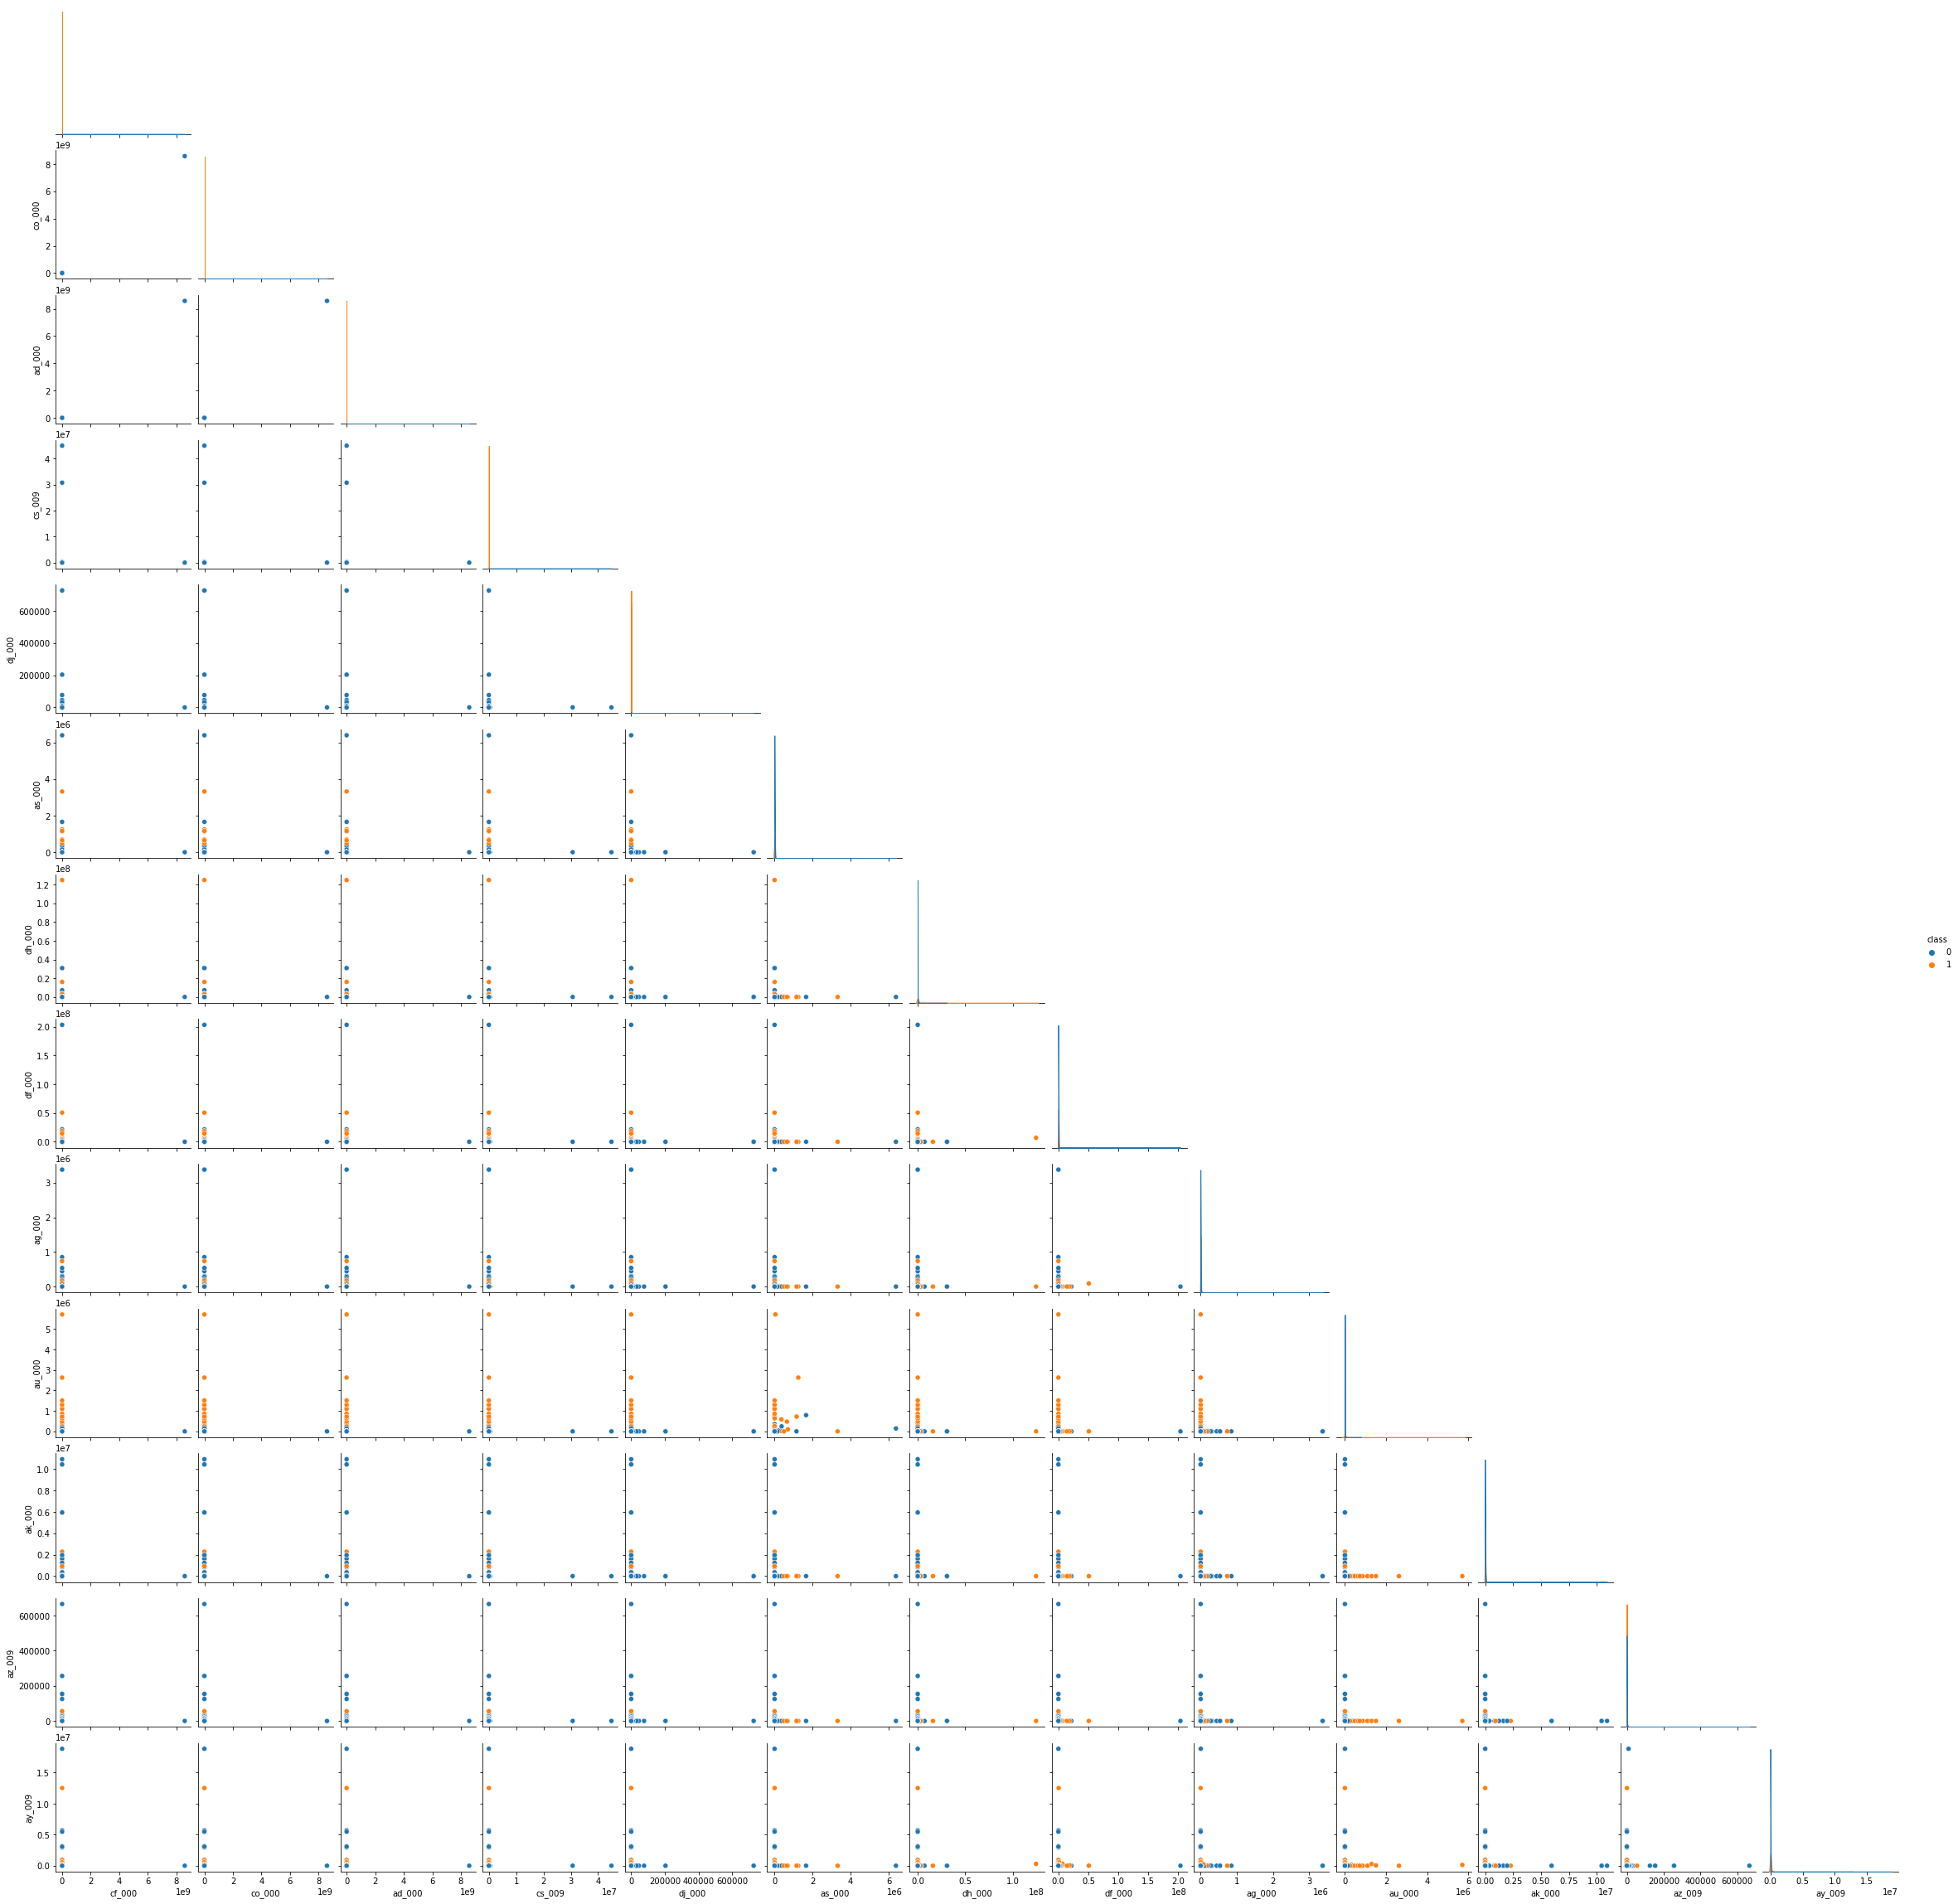

In [8]:
sbn.pairplot(data=plot_data1, hue='class', corner=True)

#### Complete scatter plot for the data. Here class 0 - Negative and 1 - Positive
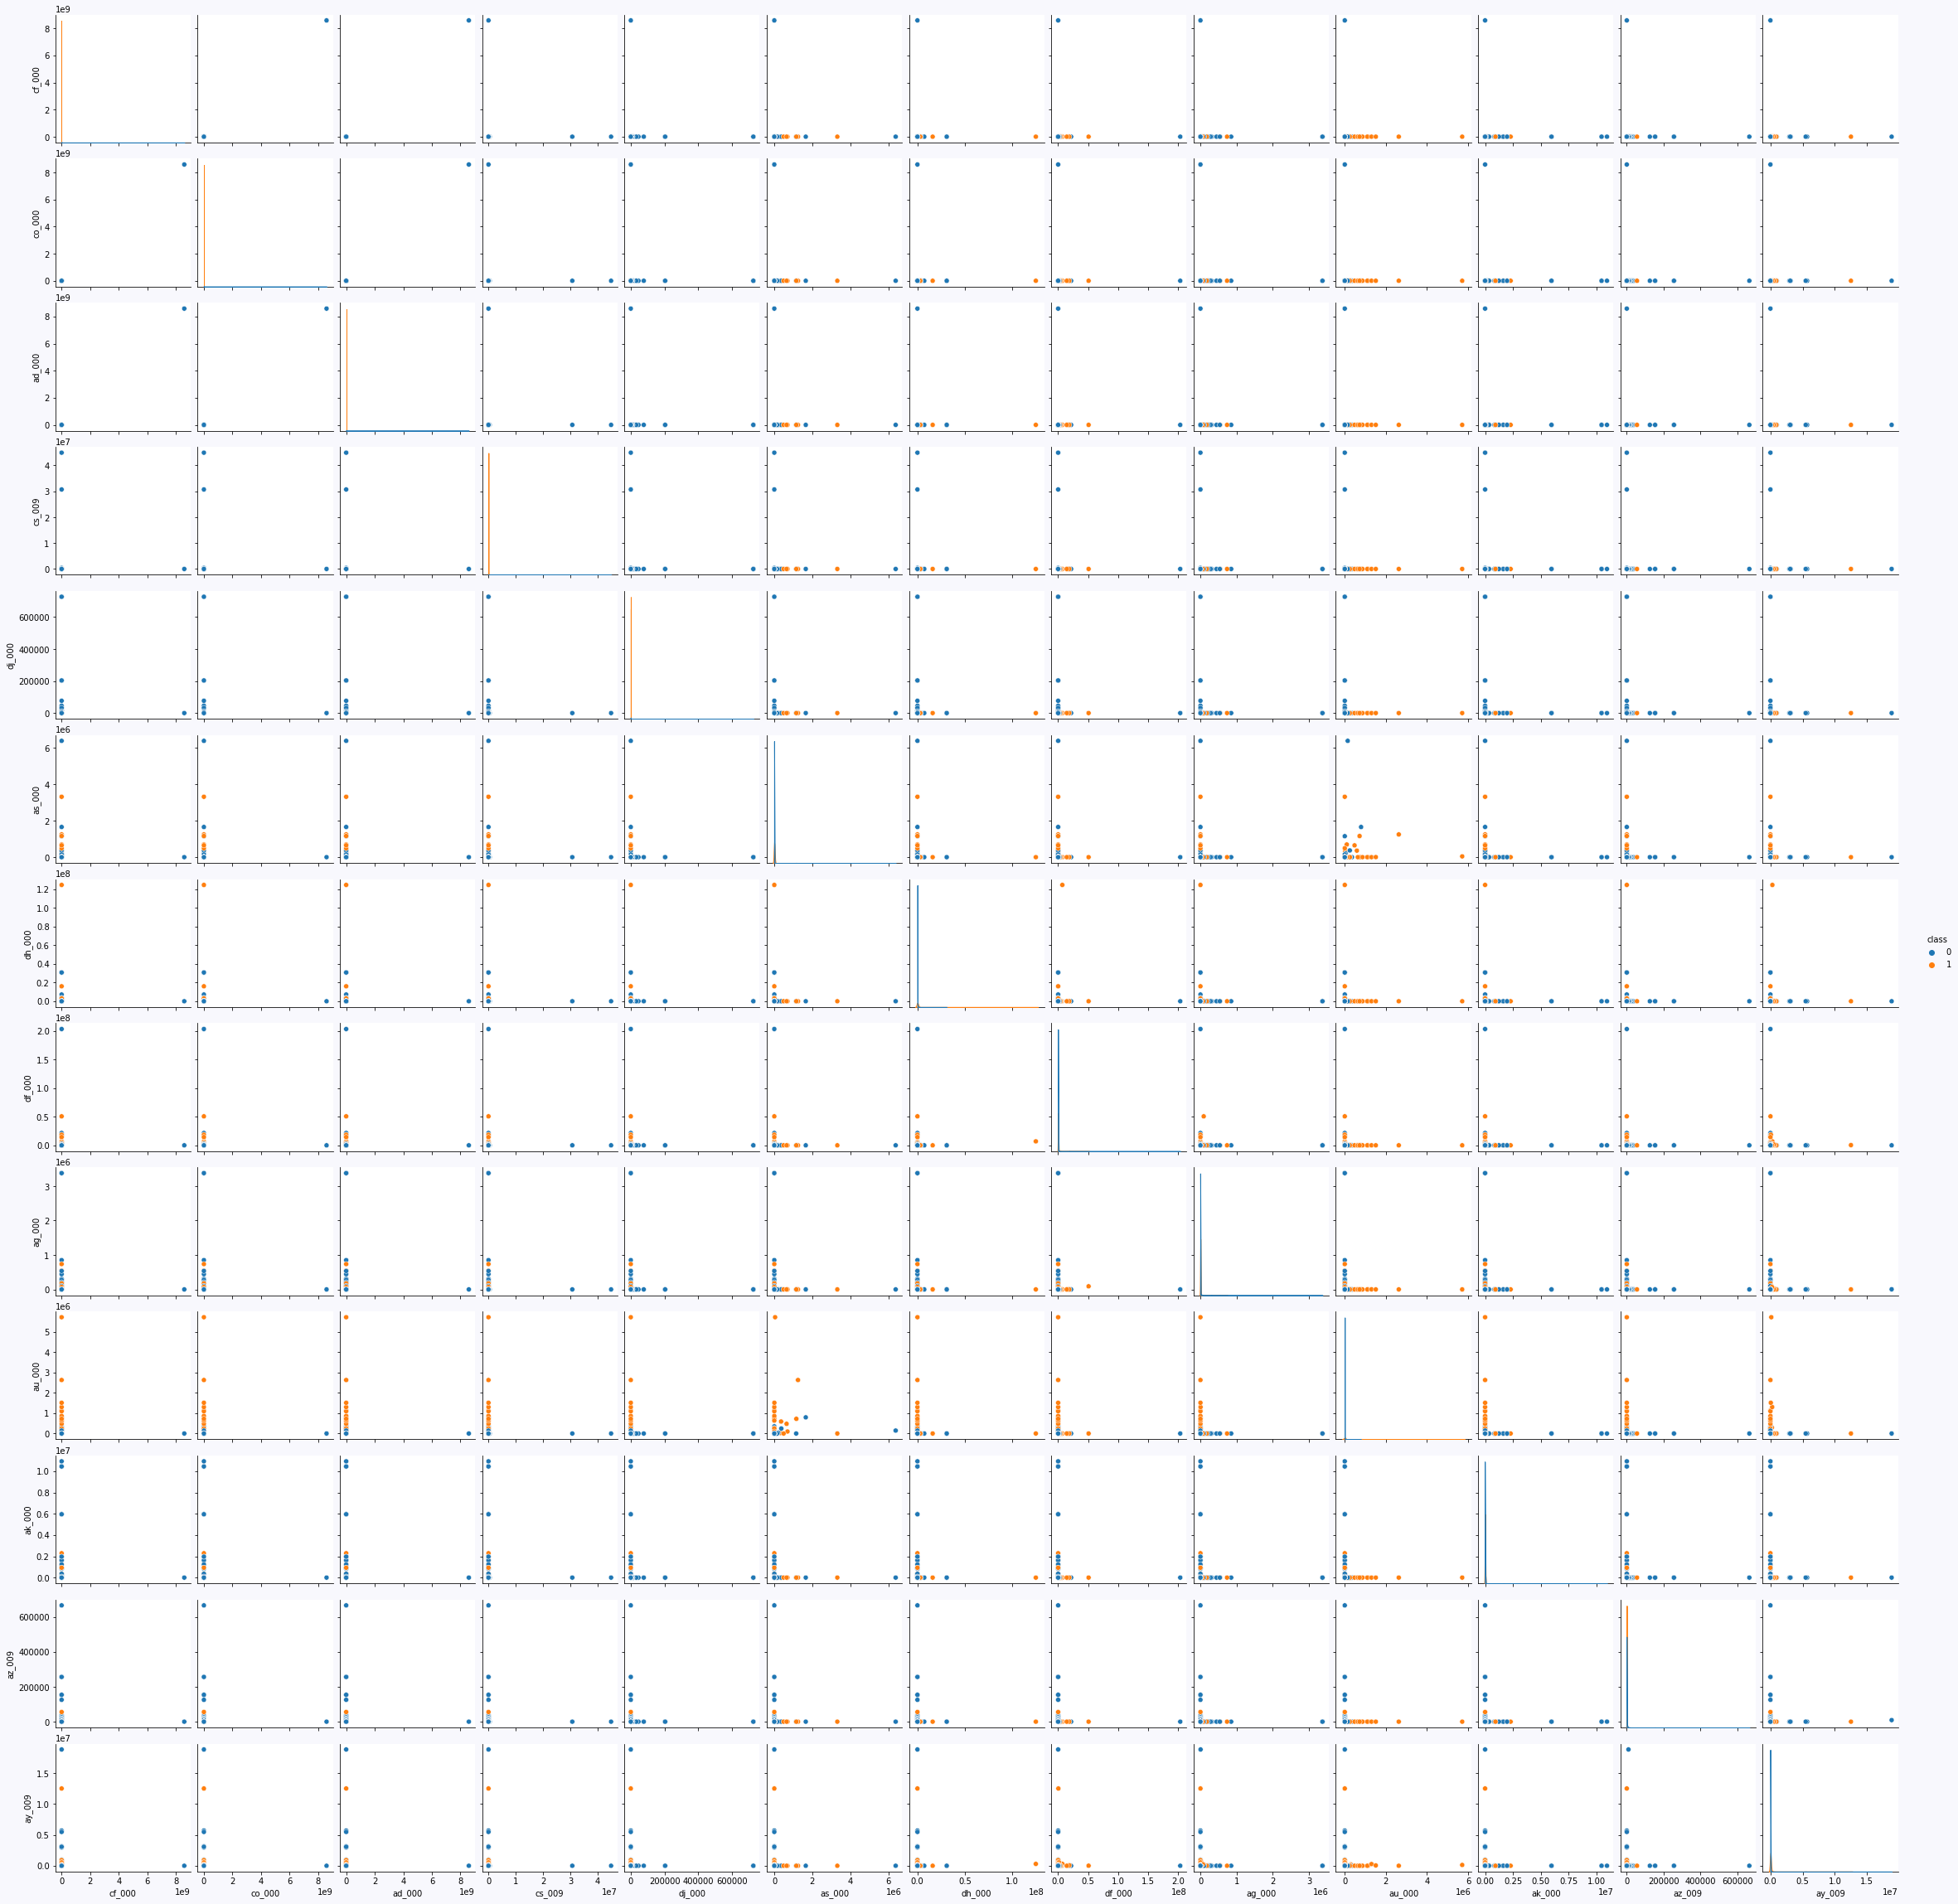

cf_000         AxesSubplot(0.1,0.736957;0.173913x0.163043)
co_000    AxesSubplot(0.308696,0.736957;0.173913x0.163043)
ad_000    AxesSubplot(0.517391,0.736957;0.173913x0.163043)
cs_009    AxesSubplot(0.726087,0.736957;0.173913x0.163043)
dj_000         AxesSubplot(0.1,0.541304;0.173913x0.163043)
as_000    AxesSubplot(0.308696,0.541304;0.173913x0.163043)
dh_000    AxesSubplot(0.517391,0.541304;0.173913x0.163043)
df_000    AxesSubplot(0.726087,0.541304;0.173913x0.163043)
ag_000         AxesSubplot(0.1,0.345652;0.173913x0.163043)
au_000    AxesSubplot(0.308696,0.345652;0.173913x0.163043)
ak_000    AxesSubplot(0.517391,0.345652;0.173913x0.163043)
az_009    AxesSubplot(0.726087,0.345652;0.173913x0.163043)
ay_009             AxesSubplot(0.1,0.15;0.173913x0.163043)
dtype: object

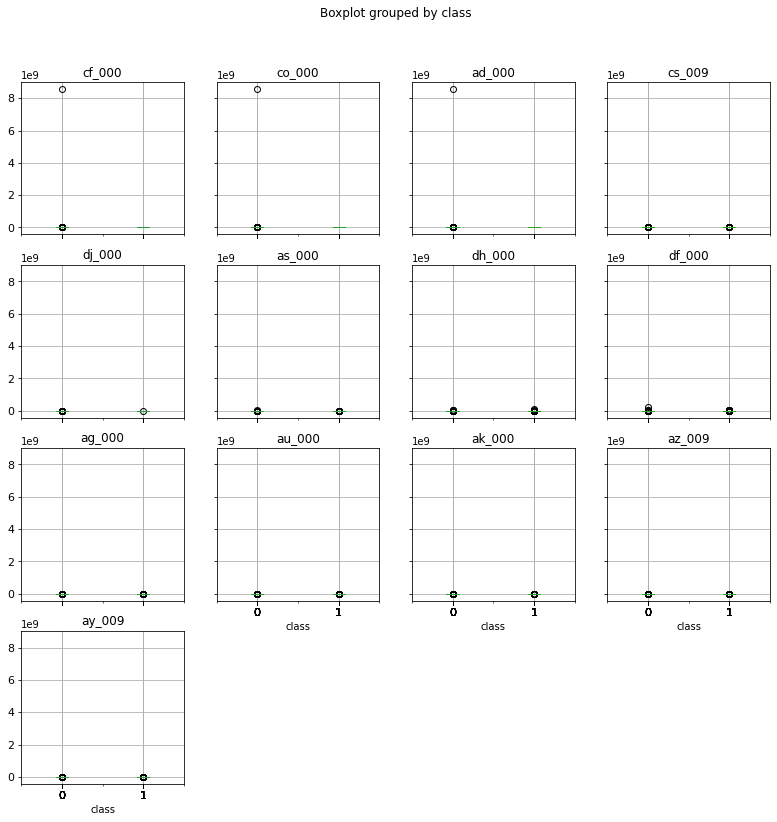

In [9]:
plot_data1.boxplot(column=top_features.values.tolist(), by='class', fontsize=11, figsize=(13, 13), return_type='axes')

#### Findings

##### The scatter plot shows us that there are some features that can be seperated linearly.


#### 1(b) v.Determine the number of positive and negative data. Is this data set imbalanced?

In [10]:
count_train = list(y_train['class'].value_counts())
count_test = list(y_test['class'].value_counts())
display(pd.DataFrame([['Neg',count_train[0],count_test[0]],['Pos',count_train[1],count_test[1]]], columns = ['Instance Type','Training Data', 'Testing Data']))
#0- negative, 1-positive

Instance Type  Training Data  Testing Data
0           Neg          59000         15625
1           Pos           1000           375

#### 1(c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

In [11]:
def plot_confusion_matrix(actual, pred):
    cm = confusion_matrix(actual, pred)
    plt.figure()
    ax= plt.subplot()
    sbn.heatmap(cm, annot=True, fmt='g', ax=ax)
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(['negative', 'positive'])
    ax.yaxis.set_ticklabels(['positive', 'negative'])
    return cm

In [12]:
def plot_roc(actual,pred):
    fpr, tpr, _ = roc_curve(actual,pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='green',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='purple', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

FOR TRAINING DATA:


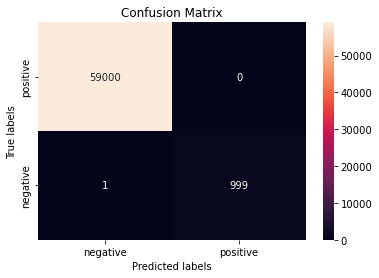

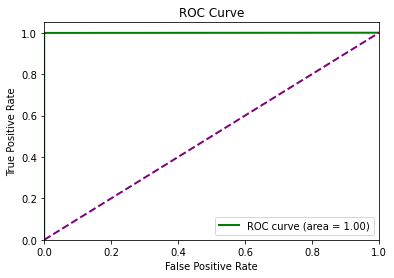

Train Error:  0.0
Misclassification:  1
Area Under Curve:  0.9995
--------------------------------------------------------
FOR TESTING DATA:


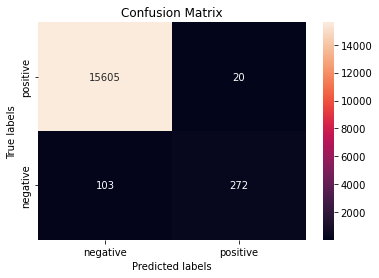

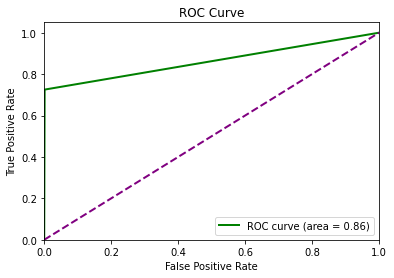

Test Error:  0.008
Misclassification:  123
Area Under Curve:  0.8620266666666667
--------------------------------------------------------
Out Of Bag Error for Random Forest Model:  0.006166666666666654
--------------------------------------------------------


In [13]:
RFC_model = RandomForestClassifier(random_state=42, oob_score=True)
RFC_model.fit(X_train,y_train)

print("FOR TRAINING DATA:")
y_pred_train_rfc = RFC_model.predict(X_train)
acc_train_rfc = accuracy_score(y_train, y_pred_train_rfc)
cm_train = plot_confusion_matrix(y_train,y_pred_train_rfc)
auc_train = plot_roc(y_train,y_pred_train_rfc)
print("Train Error: ",round(1-acc_train_rfc,3))
print("Misclassification: ", cm_train[0][1]+cm_train[1][0])
print("Area Under Curve: ", auc_train)

print("--------------------------------------------------------")

print("FOR TESTING DATA:")
y_pred_test_rfc = RFC_model.predict(X_test)
acc_test_rfc = accuracy_score(y_test, y_pred_test_rfc)
cm_test = plot_confusion_matrix(y_test,y_pred_test_rfc)
auc_test = plot_roc(y_test,y_pred_test_rfc)
print("Test Error: ",round(1-acc_test_rfc,3))
print("Misclassification: ", cm_test[0][1]+cm_test[1][0])
print("Area Under Curve: ", auc_test)

print("--------------------------------------------------------")
oob_error = 1-RFC_model.oob_score_
print('Out Of Bag Error for Random Forest Model: ', oob_error)
print("--------------------------------------------------------")

#### Findings - From the output we can see that the out of bag error is approximately similar to the test error on the tested data. Hence we can conclude that accuracy can be esitmated from the OOB score for the Randome Forest Classifier

#### 1(d)Research how class imbalance is addressed in random forests. Compensate forclass imbalance in your random forest and repeat 1c. Compare the results with those of 1c.

##### The random forest model is built on decision trees, and decision trees are sensitive to class imbalance. Each tree is built on a "bag", and each bag is a uniform random sample from the data (with replacement). Therefore each tree will be biased in the same direction and magnitude (on average) by class imbalance.
##### Moreover, in order to mitigate the imbalance in classification, Python has, weighted tree splitting implementation in the Scikit-learn class RandomForestClassifier, as the class_weight parameter.Note that the Imbalanced-learn BalancedRandomForestClassifier also supports the same class_weight parameter as the Scikit-learn RandomForestClassifier.

FOR TRAINING DATA:


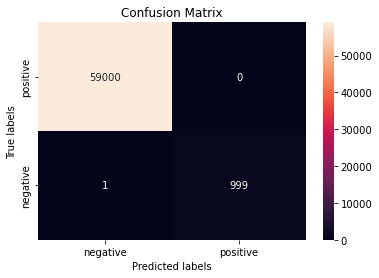

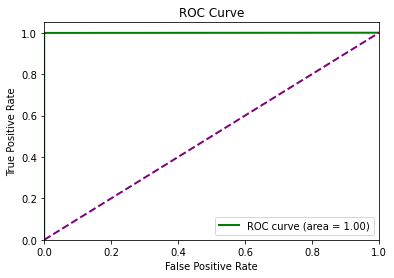

Train Error:  0.0
Misclassification:  1
Area Under Curve:  0.9995
--------------------------------------------------------
FOR TESTING DATA:


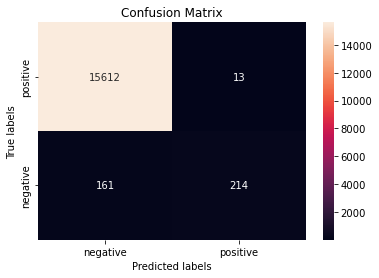

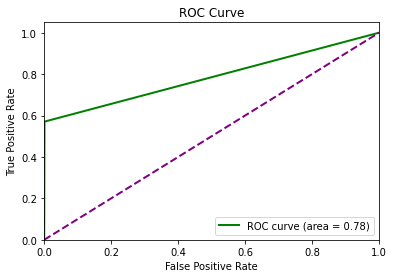

Test Error:  0.011
Misclassification:  174
Area Under Curve:  0.7849173333333332
--------------------------------------------------------
Out Of Bag Error for Random Forest Model:  0.007433333333333292
--------------------------------------------------------


In [14]:
RFC_model_bal = RandomForestClassifier(random_state=42, oob_score=True, class_weight = "balanced_subsample")
RFC_model_bal.fit(X_train,y_train)

print("FOR TRAINING DATA:")
y_pred_train_rfc_bal = RFC_model_bal.predict(X_train)
acc_train_rfc_bal = accuracy_score(y_train, y_pred_train_rfc_bal)
cm_train_bal = plot_confusion_matrix(y_train,y_pred_train_rfc_bal)
auc_train_bal = plot_roc(y_train,y_pred_train_rfc_bal)
print("Train Error: ",round(1-acc_train_rfc_bal,3))
print("Misclassification: ", cm_train_bal[0][1]+cm_train_bal[1][0])
print("Area Under Curve: ", auc_train_bal)

print("--------------------------------------------------------")

print("FOR TESTING DATA:")
y_pred_test_rfc_bal = RFC_model_bal.predict(X_test)
acc_test_rfc_bal = accuracy_score(y_test, y_pred_test_rfc_bal)
cm_test_bal = plot_confusion_matrix(y_test,y_pred_test_rfc_bal)
auc_test_bal = plot_roc(y_test,y_pred_test_rfc_bal)
print("Test Error: ",round(1-acc_test_rfc_bal,3))
print("Misclassification: ", cm_test_bal[0][1]+cm_test_bal[1][0])
print("Area Under Curve: ", auc_test_bal)

print("--------------------------------------------------------")
oob_error_bal = 1-RFC_model_bal.oob_score_
print('Out Of Bag Error for Random Forest Model: ', oob_error_bal)
print("--------------------------------------------------------")

In [15]:
display(pd.DataFrame([['Test Error',round(1-acc_test_rfc,3),round(1-acc_test_rfc_bal,3)],['Misclassification',cm_test[0][1]+cm_test[1][0],cm_test_bal[0][1]+cm_test_bal[1][0]],['Area Under Curve',auc_test,auc_test_bal]], columns = ['Output Type','without compensation', 'with compensation']))

Output Type  without compensation  with compensation
0         Test Error              0.008000           0.011000
1  Misclassification            123.000000         174.000000
2   Area Under Curve              0.862027           0.784917

#### Findings -  from the above comparison it is clear that with compensation the test error, misclassifications are slightly higher. This is for the obvious reason that extra data values were added in order to compensate the imbalance.

#### 1(e)XGBoost and Model Trees

#### You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation. Train the model for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion Matrix, ROC, and AUC for training and test sets.

Best alpha for XGBoost is:  0.01
FOR TRAINING DATA:


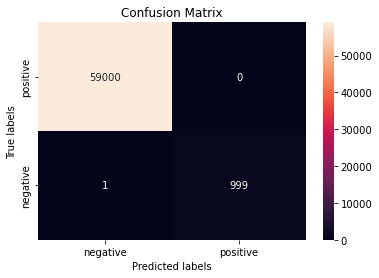

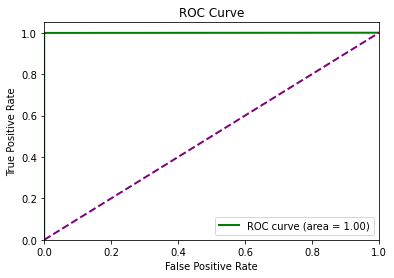

Train Error:  0.0
Misclassification:  1
Area Under Curve:  0.9995
--------------------------------------------------------
FOR TESTING DATA:


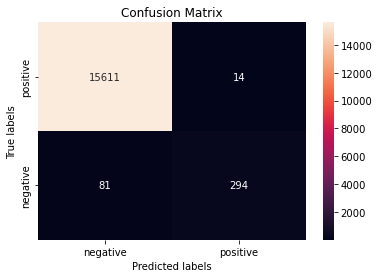

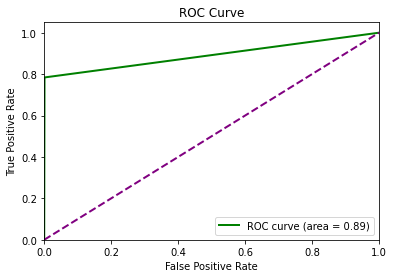

Test Error:  0.006
Misclassification:  95
Area Under Curve:  0.891552


In [16]:
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')
xgb_params = {'reg_alpha': [1e+4, 1e-3, 1e-2, 1e-1, 1, 1e+1, 1e+2, 1e+3, 1e+4]}
xgb_model_cv = GridSearchCV(xgb_model, xgb_params, cv=5)
xgb_model_cv = xgb_model_cv.fit(X_train, y_train)

best_alpha_xgb = xgb_model_cv.best_params_['reg_alpha']
xgb_model_final = xgb.XGBClassifier(reg_alpha=best_alpha_xgb,eval_metric='mlogloss')
xgb_model_final = xgb_model_final.fit(X_train, y_train)
print('Best alpha for XGBoost is: ', best_alpha_xgb)

print("FOR TRAINING DATA:")
y_pred_train_xgb = xgb_model_final.predict(X_train)
acc_train_xgb = accuracy_score(y_train, y_pred_train_xgb)
cm_train_xgb = plot_confusion_matrix(y_train,y_pred_train_xgb)
auc_train_xgb = plot_roc(y_train,y_pred_train_xgb)
print("Train Error: ",round(1-acc_train_xgb,3))
print("Misclassification: ", cm_train_xgb[0][1]+cm_train_xgb[1][0])
print("Area Under Curve: ", auc_train_xgb)

print("--------------------------------------------------------")

print("FOR TESTING DATA:")
y_pred_test_xgb = xgb_model_final.predict(X_test)
acc_test_xgb = accuracy_score(y_test, y_pred_test_xgb)
cm_test_xgb= plot_confusion_matrix(y_test,y_pred_test_xgb)
auc_test_xgb= plot_roc(y_test,y_pred_test_xgb)
print("Test Error: ",round(1-acc_test_xgb,3))
print("Misclassification: ", cm_test_xgb[0][1]+cm_test_xgb[1][0])
print("Area Under Curve: ", auc_test_xgb)

#### 1(f)Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance.Train XGBosst with L1-penalized logistic regression at each node using the pre-processed data and repeat 1e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE case.

In [17]:
pipeline = imbpipeline(steps = [['smote', SMOTE(sampling_strategy='all',random_state=42)],['classifier', xgb.XGBClassifier(eval_metric='mlogloss')]])
param_grid = {'classifier__reg_alpha':[1e+4, 1e-3, 1e-2, 1e-1, 1, 1e+1, 1e+2, 1e+3, 1e+4]}
xgb_model_cv_ = GridSearchCV(estimator=pipeline,param_grid = param_grid, cv=5, n_jobs=-1)
xgb_model_cv_.fit(X_train, y_train.values.ravel())
best_alpha_xgb_ = xgb_model_cv_.best_params_['classifier__reg_alpha']
print("--------------------------------------------------------------------------------")
print("XGBoost with SMOTE - You need to perform SMOTE within each fold(right way).")
print("--------------------------------------------------------------------------------")
print('Best alpha for XGBoost is: ', best_alpha_xgb_)


/Users/rashmibhaskar/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/rashmibhaskar/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/rashmibhaskar/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/rashmibhaskar/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed fr

/Users/rashmibhaskar/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/rashmibhaskar/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/rashmibhaskar/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do

/Users/rashmibhaskar/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/rashmibhaskar/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/rashmibhaskar/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do

/Users/rashmibhaskar/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/rashmibhaskar/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/rashmibhaskar/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do

/Users/rashmibhaskar/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/rashmibhaskar/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/rashmibhaskar/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do

--------------------------------------------------------------------------------
XGBoost with SMOTE - You need to perform SMOTE within each fold(right way).
--------------------------------------------------------------------------------
Best alpha for XGBoost is:  0.1


On applying SMOTE to Training Data


Instance Type  Value
0           Neg  59000
1           Pos  59000

FOR TRAINING DATA:


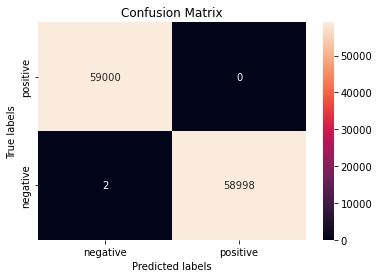

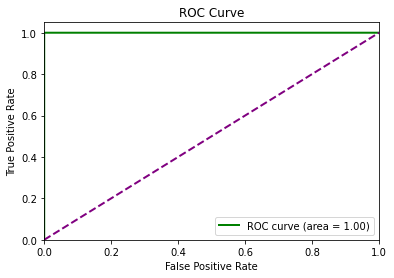

Train Error:  1.694915254235596e-05
Misclassification:  2
Area Under Curve:  0.9999830508474576
--------------------------------------------------------
FOR TESTING DATA:


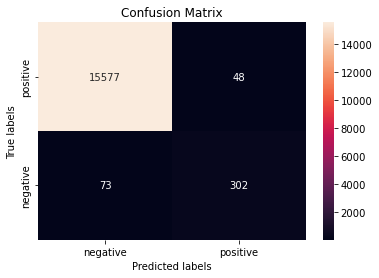

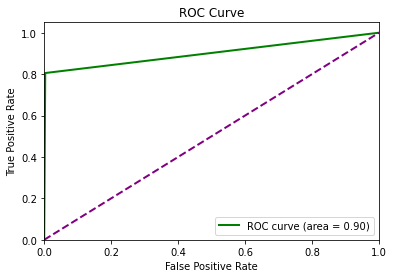

Test Error:  0.0075625000000000275
Misclassification:  121
Area Under Curve:  0.9011306666666669


In [18]:
sm = SMOTE(sampling_strategy='all',random_state=42)
X_train_after, y_train_after = sm.fit_resample(X_train,y_train)
count_value_after = pd.DataFrame(y_train_after).value_counts()
print('On applying SMOTE to Training Data')
display(pd.DataFrame([['Neg',count_value_after[0]],['Pos',count_value_after[1]]],columns= ['Instance Type', 'Value']))

xgb_model_final_ = xgb.XGBClassifier(reg_alpha=best_alpha_xgb_,eval_metric='mlogloss')
xgb_model_final_ = xgb_model_final_.fit(X_train_after, y_train_after)

print("FOR TRAINING DATA:")
y_pred_train_xgb_ = xgb_model_final_.predict(X_train_after)
acc_train_xgb_ = accuracy_score(y_train_after, y_pred_train_xgb_)
cm_train_xgb_ = plot_confusion_matrix(y_train_after,y_pred_train_xgb_)
auc_train_xgb_ = plot_roc(y_train_after,y_pred_train_xgb_)
print("Train Error: ",1-acc_train_xgb_)
print("Misclassification: ", cm_train_xgb_[0][1]+cm_train_xgb_[1][0])
print("Area Under Curve: ", auc_train_xgb_)

print("--------------------------------------------------------")

print("FOR TESTING DATA:")
y_pred_test_xgb_ = xgb_model_final_.predict(X_test)
acc_test_xgb_ = accuracy_score(y_test, y_pred_test_xgb_)
cm_test_xgb_= plot_confusion_matrix(y_test,y_pred_test_xgb_)
auc_test_xgb_= plot_roc(y_test,y_pred_test_xgb_)
print("Test Error: ",1-acc_test_xgb_)
print("Misclassification: ", cm_test_xgb_[0][1]+cm_test_xgb_[1][0])
print("Area Under Curve: ", auc_test_xgb_)

#### ISLR 6.6.3

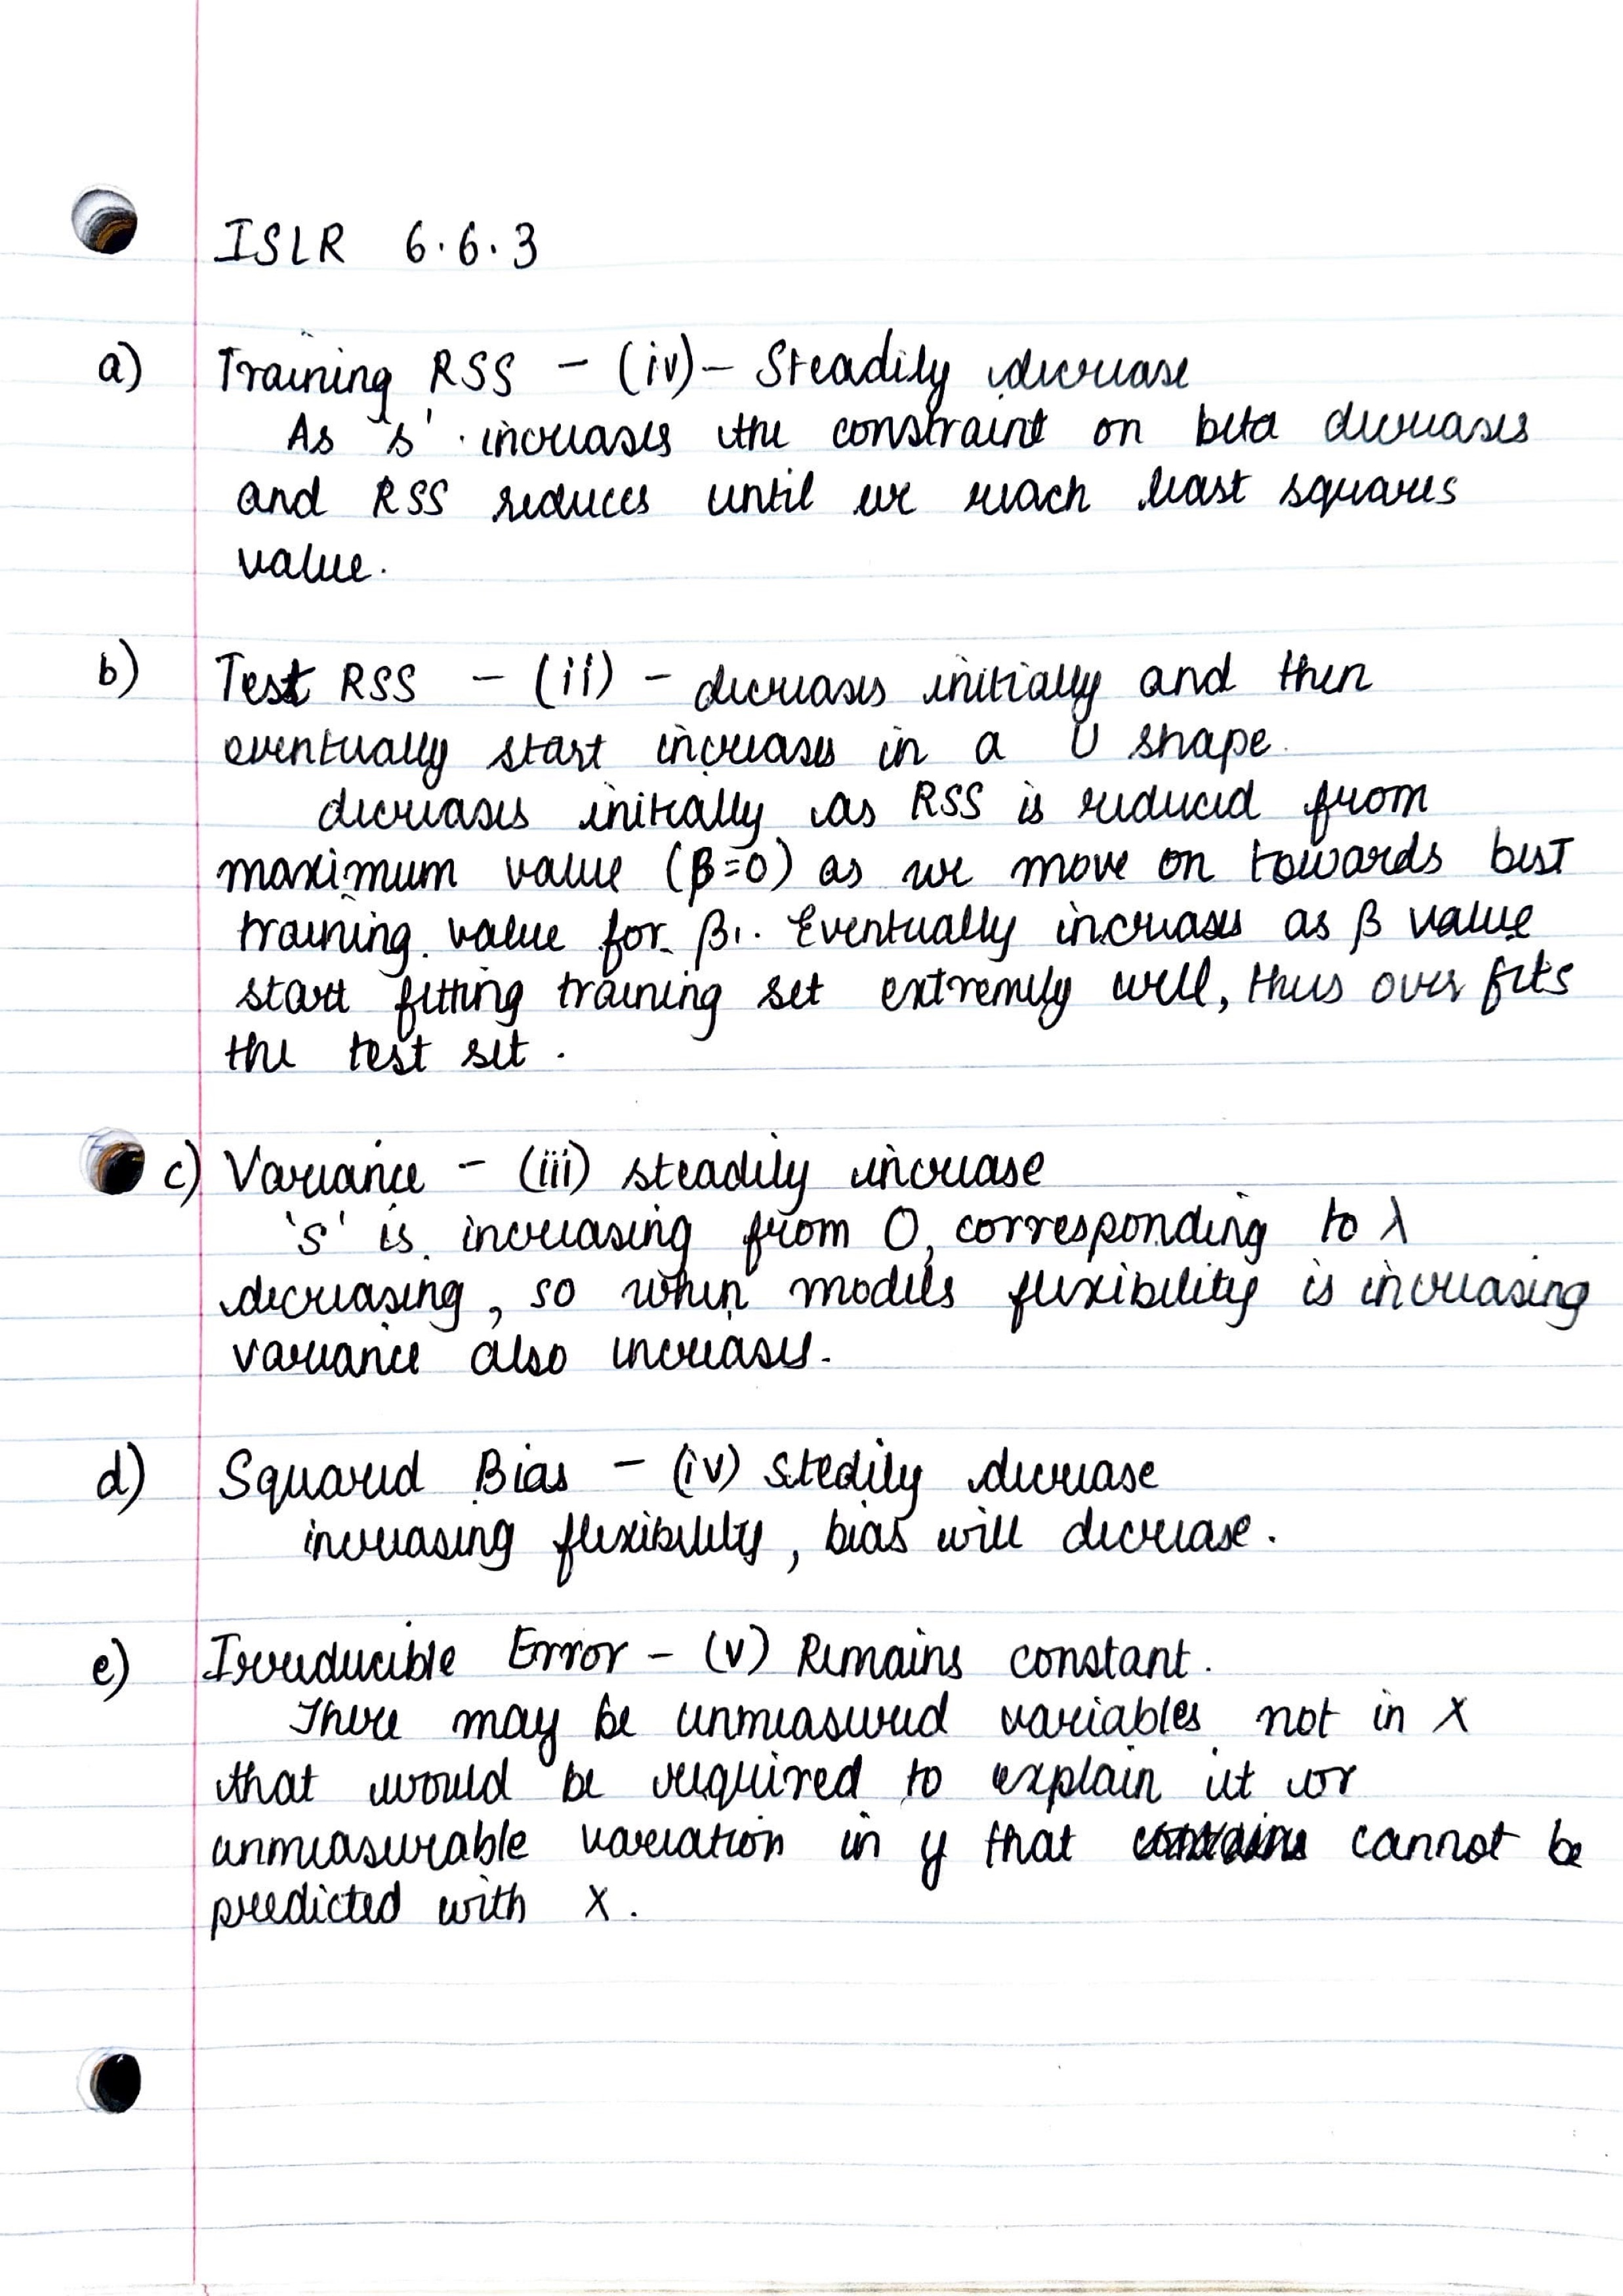

#### ISLR 6.6.5

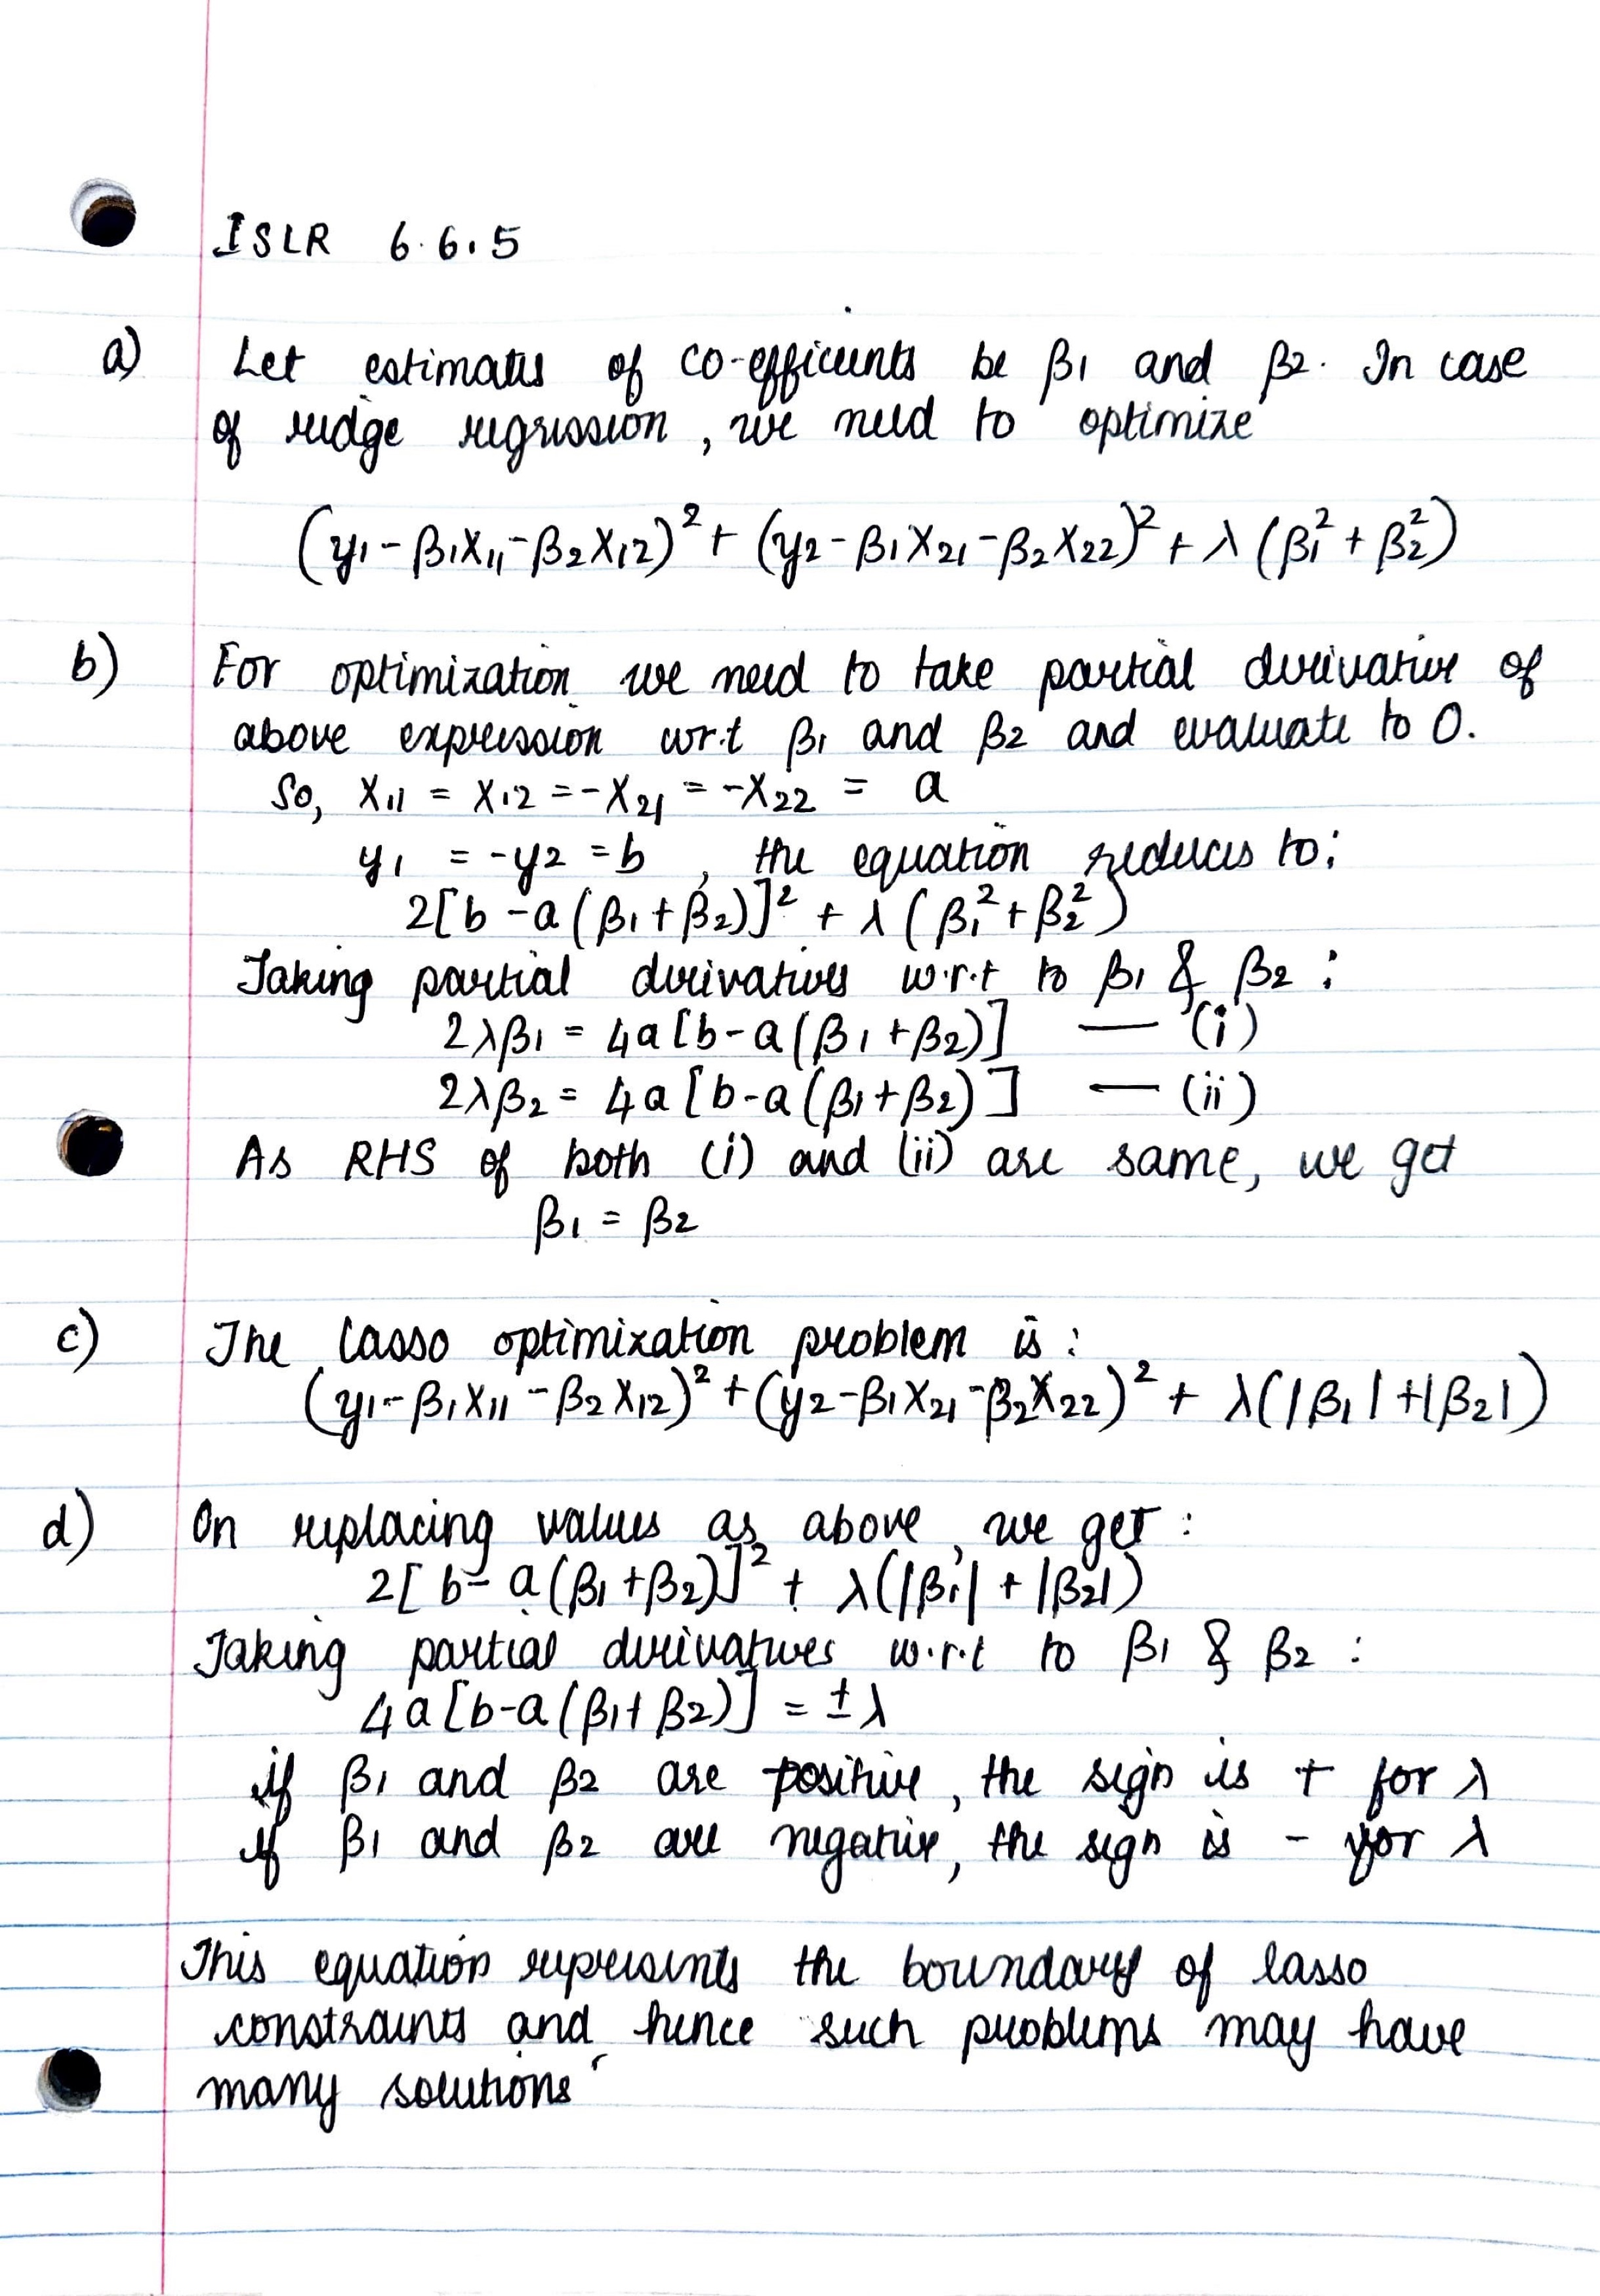

#### ISLR 8.4.5

####  Assuming a threshold in 0.5, using the majority vote the final classification would be “Red”, but using the average probability the final classification would be “Green” (average probability is 0.45).

#### ISLR 9.7.3
#### (a) We are given n = 7 observations in p = 2 dimensions. For each observation, there is an associated class label.

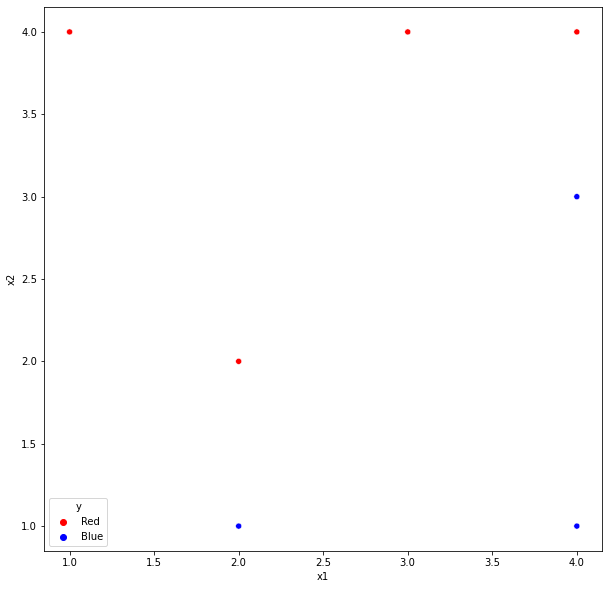

In [19]:
x1 = [3, 2, 4, 1, 2, 4, 4]
x2 = [4, 2, 4, 4, 1, 3, 1]
y = ['Red', 'Red', 'Red', 'Red', 'Blue', 'Blue', 'Blue']
plot_df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})
plt.figure(figsize=(10,10))
ax = sbn.scatterplot(x='x1', y='x2', hue='y', data=plot_df, palette={'Red':'red','Blue':'blue'})

#### (b) Sketch the optimal separating hyperplane, and provide the equa- tion for this hyperplane (of the form (9.1)).
#### Solution - The optimal separating hyperplane is given by: −0.5+X1−X2=0

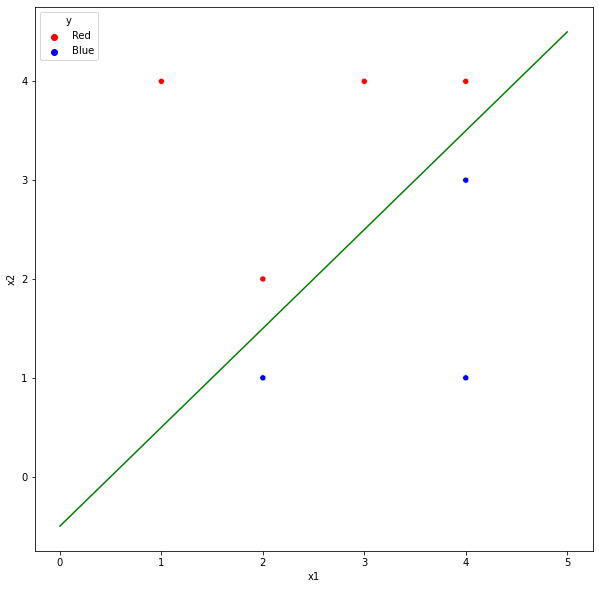

In [20]:
X1 = np.linspace(0, 5, 10)
X2 = X1 - 0.5
plot_df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})
plt.figure(figsize=(10,10))
ax = sbn.scatterplot(x='x1', y='x2', hue='y', data=plot_df, palette={'Red':'red','Blue':'blue'})
ax.plot(X1, X2, color='g')

#### (c) Describe the classification rule for the maximal margin classifier. It should be something along the lines of “Classify to Red if β0 + β1X1 + β2X2 > 0, and classify to Blue otherwise.” Provide the values for β0, β1, and β2.

#### Solution: Classify to Blue if: −0.5+X1−X2>0 and Red otherwise.

#### (d) On your sketch, indicate the margin for the maximal margin hyperplane.

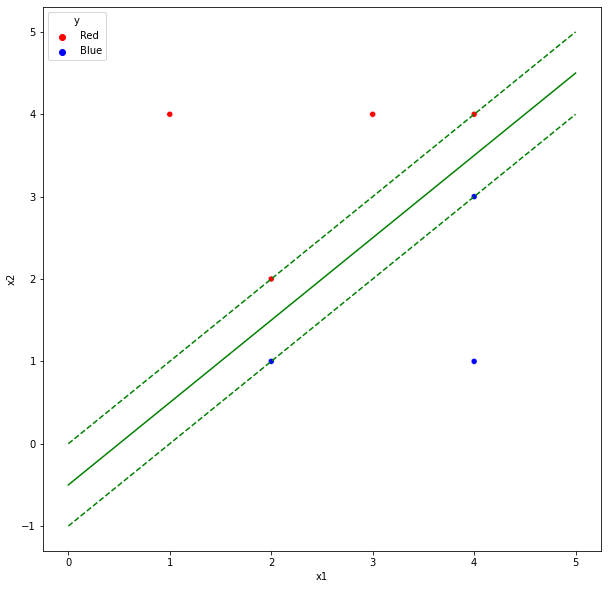

In [21]:
margin_upper = X1
margin_lower = X1 -1
plot_df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})
plt.figure(figsize=(10,10))
ax = sbn.scatterplot(x='x1', y='x2', hue='y', data=plot_df, palette={'Red':'red','Blue':'blue'})
ax.plot(X1, X2, color='g')
ax.plot(X1, margin_upper, linestyle='--', color='g')
ax.plot(X1, margin_lower, linestyle='--', color='g')

#### (e) Indicate the support vectors for the maximal margin classifier.

#### Solution -  The support vectors are those observations that lie on the dashed margins

#### (f) Argue that a slight movement of the seventh observation would not affect the maximal margin hyperplane.

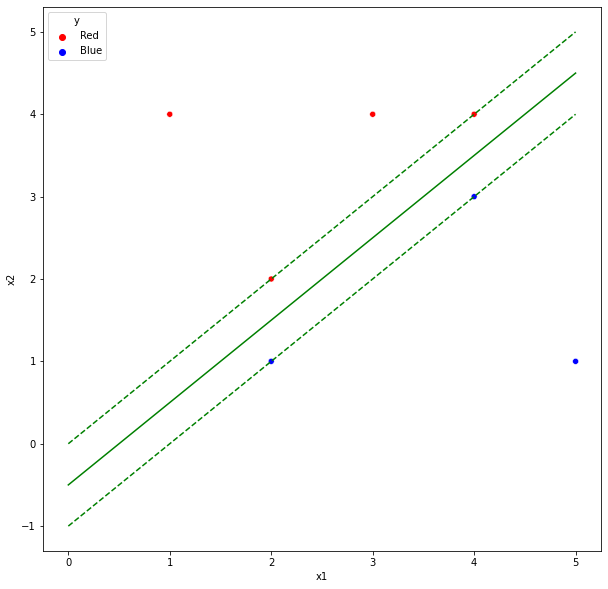

In [22]:
x11 = [3, 2, 4, 1, 2, 4, 5]
plot_df = pd.DataFrame({'x1':x11, 'x2':x2, 'y':y})
plt.figure(figsize=(10,10))
ax = sbn.scatterplot(x='x1', y='x2', hue='y', data=plot_df, palette={'Red':'red','Blue':'blue'})
ax.plot(X1, X2, color='g')
ax.plot(X1, margin_upper, linestyle='--', color='g')
ax.plot(X1, margin_lower, linestyle='--', color='g')

#### Here I've moved the 7th observation bottom-right by increasing its x1 value by +1. This does not affect the maximal margin hyperplane because this observation is not a support vector.

#### If, however, I had decreased the x1 value by -2.5 then this observation would have entered the margin and so would become a support vector, at this point it would begin to have an affect on the maximal margin hyperplan.

#### (g) Sketch a hyperplane that is not the optimal separating hyper- plane, and provide the equation for this hyperplane.

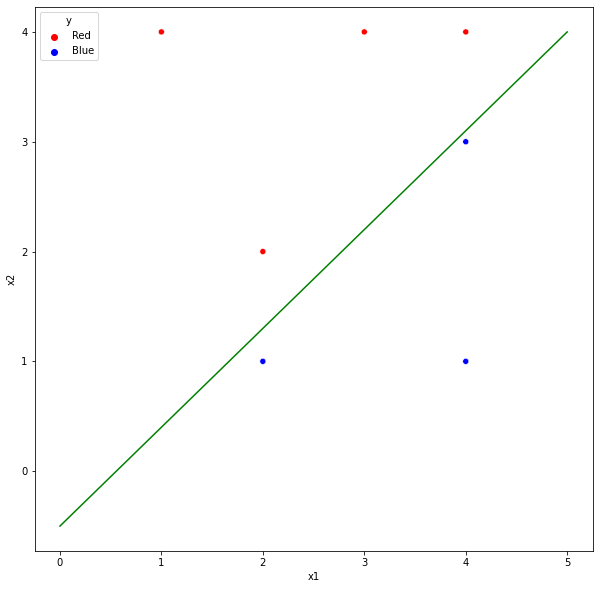

In [23]:
X1 = np.linspace(0, 5, 10)
X2 = 0.9*X1 - 0.5
plot_df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})
plt.figure(figsize=(10,10))
ax = sbn.scatterplot(x='x1', y='x2', hue='y', data=plot_df, palette={'Red':'red','Blue':'blue'})
ax.plot(X1, X2, color='g')

#### (h) Draw an additional observation on the plot so that the two classes are no longer separable by a hyperplane.

#### Solution - I've added the observation (2, 3)

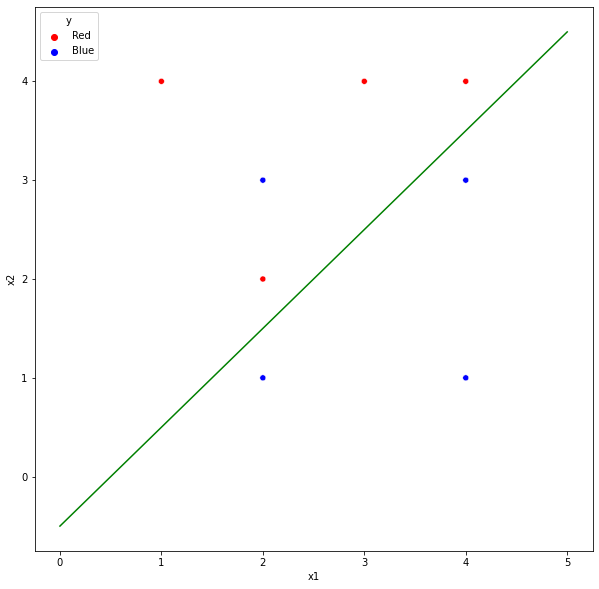

In [24]:
x1.append(2)
x2.append(3)
y.append('Blue')
X1 = np.linspace(0, 5, 10)
X2 = X1 - 0.5
plot_df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})
plt.figure(figsize=(10,10))
ax = sbn.scatterplot(x='x1', y='x2', hue='y', data=plot_df, palette={'Red':'red','Blue':'blue'})
ax.plot(X1, X2, color='g')

#### References/Links

[1] - https://galaxyinferno.com/how-to-impute-missing-values-with-python/

[2] - https://towardsdatascience.com/imputing-numerical-data-top-5-techniques-every-data-scientist-must-know-587c0f51552a

[3] - https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779

[4] - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

[5] - https://stats.stackexchange.com/questions/242833/is-random-forest-a-good-option-for-unbalanced-data-classification

[6] - https://xgboost.readthedocs.io/en/stable/tutorials/model.html

[7] - https://towardsdatascience.com/combining-logistic-regression-and-decision-tree-1adec36a4b3f

[8] - https://stackoverflow.com/questions/66097701/how-can-i-fix-this-warning-in-xgboost

[9] - https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7

[10] - https://nbviewer.org/github/a-martyn/ISL-python/blob/master/Notebooks/ch9_support_vector_machines_conceptual.ipynb

[11] - https://stackoverflow.com/questions/55591063/how-to-perform-smote-with-cross-validation-in-sklearn-in-python

[12] - https://stackoverflow.com/questions/50245684/using-smote-with-gridsearchcv-in-scikit-learn

[13] - https://stackoverflow.com/questions/49466519/what-is-the-difference-between-the-default-cv-in-gridsearch-and-kfold
